In [1]:
import numpy as np
import xarray as xr

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

from preprocessingTools import *

# Conversion to netCDF & visualization

Transforming Calypso outputs to a xarray.Dataarray, then to saving to netCDF format (note the data is too big to upload on github)

In [2]:
%time temperature = dat_to_xarray("data/data808/picked_mode_temperatureonly_100r.dat")
temperature

CPU times: user 28.3 s, sys: 13.2 s, total: 41.5 s
Wall time: 51.7 s


<xarray.Dataset>
Dimensions:      (degree: 253, order: 1, radius_ID: 100, t_step: 800)
Coordinates:
  * t_step       (t_step) int64 16160025 16160050 16160075 ... 16179975 16180000
  * radius_ID    (radius_ID) int64 261 262 263 264 265 ... 356 357 358 359 361
  * degree       (degree) int64 3 4 5 6 7 8 9 10 ... 249 250 251 252 253 254 255
  * order        (order) int64 3
    time         (t_step) float64 7.831 7.831 7.831 7.831 ... 7.833 7.833 7.833
    radius       (radius_ID) float64 1.36 1.363 1.366 1.37 ... 1.538 1.538 1.538
Data variables:
    temperature  (t_step, radius_ID, degree, order) float64 -0.01236 ... 0.0

In [ ]:
#Save to netCDF format
temperature.to_netcdf("data/data808/temperature.nc")

xarray allows to easily differentiate the temperature field in time, giving a quick visualization of buoyancy fluctuations in the stratified layer

Text(0.5, 0, 'time (years)')

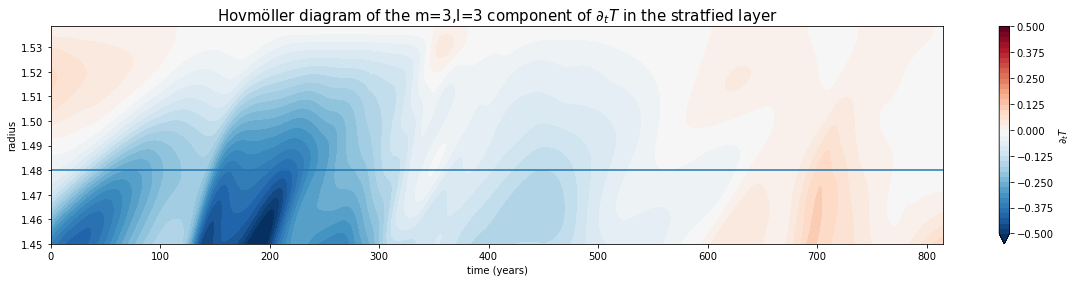

In [4]:
# Visualize a radius/time plot using xarray's plotting shortcuts

def ntsteps_to_years(n):
    L=2270e3
    pm=0.5
    eta=0.8
    return n*(L**2/eta/pm/86400/365.25 * 1e-7)

dt_temperature=(temperature.temperature.differentiate('t_step')/(25e-7)).rename(r"$\partial_t T$")
dt_temperature_plot=dt_temperature.assign_coords(time = ntsteps_to_years(temperature.t_step-temperature.t_step[0])).swap_dims({'t_step':'time','radius_ID':'radius'})

fig,ax=plt.subplots(1,1,figsize=(20,4))
dt_temperature_plot.sel(degree=3,order=3).plot.contourf(ax=ax,x='time',levels=np.linspace(-.5,.5,41))#,cmap=plt.cm.RdBu_r)

ax.set_ylim(1.45,1.5385) 
ax.axhline(1.48) # Layer base 
ax.set_title(r'Hovmöller diagram of the m=3,l=3 component of $\partial_t T$ in the stratfied layer',fontsize=15)
ax.set_xlabel('time (years)')

# Transformation to spherical coordinates

In [6]:
# Create a grid and convert from (time, radius, degree) space to (time, radius, cos(latitude)) space
ngrid=300
y = np.cos(np.linspace(0.,np.pi,ngrid+2)[1:-1][::-1]) #exclude the -1 and 1 bounds to avoid divisions by 0
%time temperature_y = interp_scalar(y, temperature.temperature, 3)

CPU times: user 3min 37s, sys: 2min 44s, total: 6min 21s
Wall time: 6min 46s


In [ ]:
temperature_y.to_netcdf("data/data808/temperature_y_300_cos.nc")

In [7]:
temperature_y

<xarray.Dataset>
Dimensions:           (radius_ID: 100, t_step: 800, y: 300)
Coordinates:
  * t_step            (t_step) int64 16160025 16160050 ... 16179975 16180000
  * radius_ID         (radius_ID) int64 261 262 263 264 265 ... 357 358 359 361
  * y                 (y) float64 -0.9999 -0.9998 -0.9995 ... 0.9998 0.9999
    time              (t_step) float64 7.831 7.831 7.831 ... 7.833 7.833 7.833
    radius            (radius_ID) float64 1.36 1.363 1.366 ... 1.538 1.538 1.538
Data variables:
    temperature_real  (t_step, radius_ID, y) float64 -0.0001677 ... 0.0
    temperature_imag  (t_step, radius_ID, y) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

Now we can visualize the buoyancy force on a spherical surface. We already have T as a function of t,r and y, so we simply need to differentiate in time, pick a time and radius, and multiply by $e^{im\phi}$ to get the $\phi$ dependence.

In [8]:
theta = np.arccos(y)
phi = np.linspace(0, 2*np.pi, ngrid)
phi_xr=xr.DataArray(phi,coords={'phi':phi},dims=['phi'])
#theta, phi = np.meshgrid(theta, phi)
phi, theta  = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
X = np.sin(theta) * np.cos(phi)
Y = np.sin(theta) * np.sin(phi)
Z = np.cos(theta)

In [9]:
dt_temperature_y=(temperature_y.differentiate('t_step')/(25e-7)).sel(t_step=0,radius_ID=1.48,method='nearest')
dt_temperature_yphi = np.real((dt_temperature_y.temperature_real+1j*dt_temperature_y.temperature_imag)*np.exp(1j*3*phi_xr))

Text(0.5, 0.92, 'm=3 component of $\\partial_t T$ at t=0 and r=1.48 (base of stratified layer)')

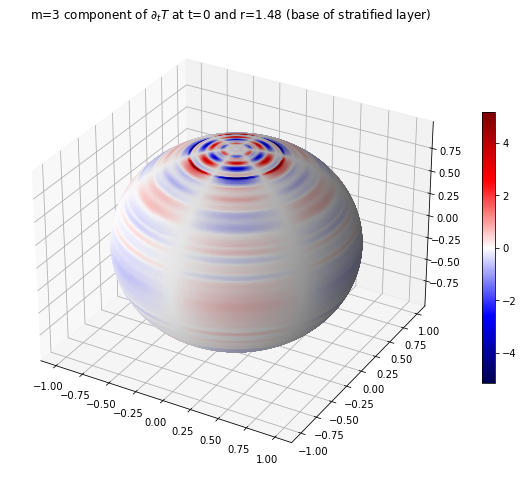

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10.,10.), subplot_kw = {'projection':'3d'})
norm = clr.Normalize(vmin=dt_temperature_yphi.min(), vmax=dt_temperature_yphi.max())
surf=ax.plot_surface(X, Y, Z,  rstride=1, cstride=1, facecolors=plt.cm.seismic(norm(dt_temperature_yphi)))
m = plt.cm.ScalarMappable(cmap=plt.cm.seismic, norm=norm)
m.set_array([])
plt.colorbar(m,shrink=0.5)

ax.set_title("m=3 component of $\partial_t T$ at t=0 and r=1.48 (base of stratified layer)")
